# Student Name:

## Problem 1 (10 points)

In this problem, we consider the optimal selection of a treatment. Suppose that there are 5 types of treatments available. The outcome of each treatment is either 1 (recovery) or 0.   

Let's denote the outcome by $R_t$, then $R_t|(A_t=a)$ follows $\text{Bernoulli}(p_a)$ with $a\in\{1,2,3,4,5\}$ and all $p_a\in [0,1]$, where $A_t$ denotes the action on time step $t=1,2,3,\ldots$. 

Assume that $p_1=0.1$, $p_2=0.3$,  $p_3=0.5$, $p_4=0.7$, $p_5=0.9$, which are not known to the doctor. This is the 5-armed Bandit Problem with Bernoulli distributions. The rewards $R_t$ are 0's and 1's. Please notice that $P\{R_t=1|A_t=a\}=p_a$. Also, the expectation $E\left[R_t|A_t=a \right]=p_a$.

Develop the Optimistic Initial Values algorithm for the problem of selecting the best treatment and report the following graphs:   
(a) Run the algorithm for $t=1,2,3,\ldots,200$ and plot $R_t$'s v.s. $t$ for one simulation.   
(b) Run the trajectory in (a) for 100 epochs; and for each time step $t$ plot the average of $R_t$'s from the epochs at time particular time (please do not average all returns over time - we want to see how the learning progresses over time).   
(c) Using trajectories you obtained in (b), for each time step $t$, plot the proportion  (out of 100) of times the best action (action $a=5$) was selected by the doctor. 

<u>Important</u>: In case you are using the Bandit algorithm from Chapter 2 of "Reinforcement Learning" by Sutton and Barto, which was developed for continuous outcome, please explain why the algorithm is applicable here. **Hint**: notice that the estimate of $p_a$ is the sample proportion of recovered patients out of the total number who were treated according to $a$, i.e. the simple average of all associated rewards $R_t$ does estimate $p_a$.

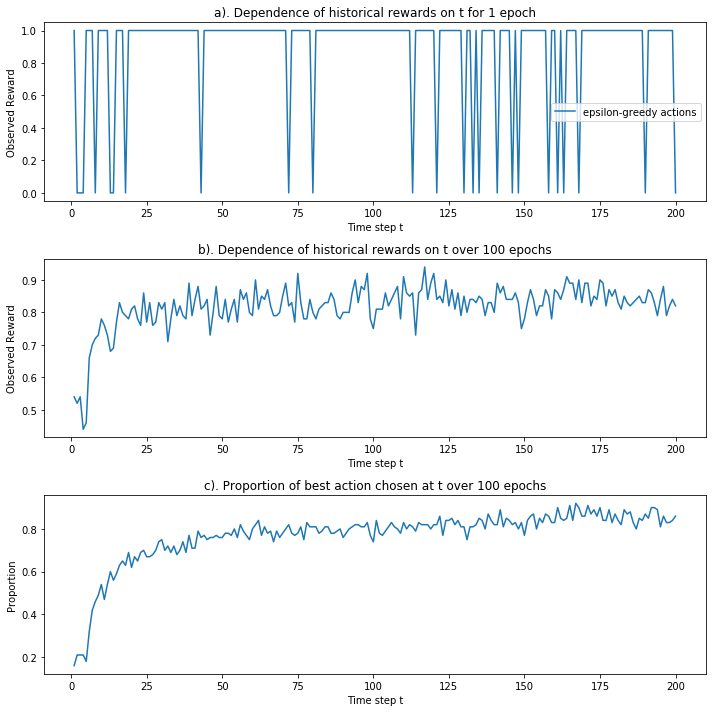

In [58]:
import random
import numpy as np

class Environment:
    def __init__(self):
        self.time = 1

    def admissible_actions(self):
        return list(range(1,6))
    
    def get_reward(self, action):
        self.time += 1
        reward_probabilities = {
            1: 0.1,
            2: 0.3,
            3: 0.5,
            4: 0.7,
            5: 0.9
        }
        rand = random.random()
        reward = 1 if rand <= reward_probabilities.get(action) else 0
        return reward

class Agent:
    def __init__(self, num_arms):
        self.current_reward = 0.0
        self.est_value = np.full(5, fill_value=2.0)
        self.n_action = np.zeros(num_arms)
        self.chosen_actions = []

    def step(self, env, epsilon):
        actions = env.admissible_actions()
        chosen_action = self.choose_action(env, actions, epsilon)
        self.chosen_actions.append(chosen_action)
        reward = env.get_reward(chosen_action)
        self.n_action[chosen_action-1] = self.n_action[chosen_action-1] + 1
        self.est_value[chosen_action-1] = self.est_value[chosen_action-1] + (1/self.n_action[chosen_action-1])*(reward-self.est_value[chosen_action-1])
        self.current_reward = reward
    
    def choose_action(self, env, actions, epsilon):
        rand_num = random.uniform(0,1)
        if rand_num <= 1-epsilon:
            chosen = np.random.choice(np.flatnonzero(self.est_value == self.est_value.max())) + 1
        else:
            chosen = random.choice(actions)
        return chosen

def rewards_hist(T = 10, epsilon = 0.0):
    env = Environment()
    agent = Agent(len(env.admissible_actions()))
    rewards = []
    while env.time <= T:
        agent.step(env, epsilon)
        rewards.append(agent.current_reward)
    best_action_chosen = (np.asarray(agent.chosen_actions) == 5)*1
    return np.asarray(rewards), best_action_chosen


from matplotlib import pyplot as plt 
import numpy as np   
T = 200
epsilon = 0.1

plt.figure(figsize=(10,10))
plt.subplot(3, 1, 1)
rewards, num_best_action = rewards_hist(T, epsilon)
plt.plot(range(1,T+1), rewards, label='epsilon-greedy actions')
plt.title('a). Dependence of historical rewards on t for 1 epoch')
plt.ylabel('Observed Reward')
plt.xlabel('Time step t')
plt.legend()

epochs = 100
all_rewards = []
best_actions = []
for i in range(0, epochs):
    rewards, best_action_chosen = rewards_hist(T, epsilon)
    all_rewards.append(rewards)
    best_actions.append(best_action_chosen)
all_rewards = np.asarray(all_rewards)
avg_rewards = (np.mean(all_rewards, axis=0))
proportion_best_actions = np.sum(best_actions, axis=0) / epochs

plt.subplot(3, 1, 2)
plt.plot(range(1,T+1), avg_rewards)
plt.title('b). Dependence of historical rewards on t over 100 epochs')
plt.ylabel('Observed Reward')
plt.xlabel('Time step t')

plt.subplot(3, 1, 3)
plt.plot(range(1,T+1), proportion_best_actions)
plt.title('c). Proportion of best action chosen at t over 100 epochs')
plt.ylabel('Proportion')
plt.xlabel('Time step t')
plt.tight_layout()
plt.show()

## Problem 2 (10 points)

In this problem, we consider the optimization of hospital patient flow using the Markov Decision Process. We assume that the hospital can hold 300 patients at most.

Further, we introduce three states as follows:   

"Low" if number of patients is in $[0,100)$   
"Medium" if number of patients is in $[101,200)$   
"High" if number of patients is in $[201,300]$    

Please notice that this aggregation is an important step as it allows one to accurately estimate the transition probabilities from state to state using the database that tracks journeys of patients through the hospital from arrival to discharge.



One time step corresponds to one day and the administration of the hospital can select the following actions:

If the hospital has "Low" number of patients, then $a \in \{0\}$, where $0$ indicates that no patient will be released early.   
If the hospital has "Medium" number of patients, then $a \in \{0,1\}$, i.e. besides action $a=0$, only one additional action is admissible, namely $1$. This action corresponds to releasing $10$ patients early.   
If the hospital has "High" number of patients, then $a \in \{0,1,2\}$, i.e. besides action $a=0$, two additional actions, namely $1$ and $2$, are admissible. Action $a=1$ again corresponds to releasing $10$ patients early, while action $2$ indicates releasing $20$ patients early.  
   
<br>
        
Further, assume that we found the transition probabilities $p(S_{t+1}=s^\prime|S_t=s,A_t=a)$ to be (for a data-driven estimates refer, for instance, to "Markov Decision Process Model for Optimisation of Patient Flow" by Clissold, J. Filar, S. Qin, and D.Ward, 21st International Congress on Modelling and Simulation, Gold Coast, Australia, 29 Nov to 4 Dec 2015):   

$p(S_{t+1}=s^\prime|S_t=s,A_t=0)=\begin{bmatrix} 
0.8 & 0.2 & 0 \\
0.25 & 0.7 & 0.05\\
0.01 & 0.25 & 0.74\\
\end{bmatrix}$    

Here, we use the Markov Chain convention with $s$ being the row index (in the order from "Low" to "High"), and $s^\prime$ being the column index.    
For example, $p(S_{t+1}=\text{"High"}|S_t=\text{"Medium"},A_t=0)=0.05$ and $p(S_{t+1}=\text{"Medium"}|S_t=\text{"Low"},A_t=0)=0.2$.

If, however, the hospital decides to release $10$ patients early, i.e. $A_t=1$, the probability of moving to a "lower" hospital occupancy level are now larger, while the probability of moving to a "higher" state are smaller:  

$p(S_{t+1}=s^\prime|S_t=s,A_t=1)=\begin{bmatrix} 
- & - & - \\
0.25+0.1 & 0.7-0.09 & 0.05-0.01\\
0.01+0.01 & 0.25+0.09 & 0.74-0.1\\
\end{bmatrix}$ 

where same $s, s^\prime$ index convention is used. Plase notice that in state $s=\text{"Low"}$ action $A_t=1$ is unavailable resuting in missing probabilities (denoted by "-") in the matrix above. On the other hand, $p(S_{t+1}=\text{"High"}|S_t=\text{"Medium"},A_t=1)=0.05-0.1$, for example.

Finally, if the decision maker selects to reaease $20$ patients early, i.e. $A_t=20$, then   

$p(S_{t+1}=s^\prime|S_t=s,A_t=2)=\begin{bmatrix} 
- & - & - \\
- & - & -\\
0.01+0.02 & 0.25+0.18 & 0.74-0.2\\
\end{bmatrix}.$   
   
<br><br>
        
The reward $R_{t+1}$ obtained as a result of action $A_t$ is defined as follows:   
$R_{t+1}=\frac{1}{10}\left[\mathbb{1}_{\{S_{t+1}=\text{"Low"}\}}\cdot 49.5+\mathbb{1}_{\{S_{t+1}=\text{"Medium"}\}}\cdot 150.5+\mathbb{1}_{\{S_{t+1}=\text{"High"}\}}\cdot 255.5 + A_t\cdot (-10)\right]+\frac{9}{10}\left[\mathbb{1}_{\{S_{t+1}=\text{"High"}\}}\cdot (-30)\right]$.

Here, the first term $\frac{1}{10}\left[\ldots\right]$ is related to the direct profit of the hospital, while the second term $\frac{9}{10}\left[\ldots\right]$ is associated with the inconvenience of patients, risk of refusal for admission of new patients, and the reputation of the hospital.

<br>

Using this information, please find the optimal policy for the decision making via the Policy <u>Iteration</u> (algorithm on p. 80 of "Reinforcement Learning" by Sutton and Barto).  

In [74]:
import collections
import numpy as np

def admissible_actions(state):
    actions = list((0,1,2))
    if state == 0: 
        actions.remove(1)
        actions.remove(2)
    if state == 1: 
        actions.remove(2)
    return actions

def admissible_states():
    return list((0,1,2))   # 0: low; 1: medium; 2: high

def get_trans_probs(action, state):
    mapping = {}
    trans_probs = np.array([[[0.80, 0.20, 0.00],
                             [0.25, 0.70, 0.05],
                             [0.01, 0.25, 0.74]],
                            [[None, None, None], 
                             [0.35, 0.61, 0.04], 
                             [0.02, 0.34, 0.64]],
                            [[None, None, None],
                             [None, None, None],
                             [0.03, 0.43, 0.72]]])
    for new_state in admissible_states():
        reward = 0.1*((new_state==0)*49.5 + (new_state==1)*150.5 + (new_state==2)*255.5 + action*-10) + 0.9*((new_state==2)*-30)
        mapping[(new_state, reward)] = trans_probs[action][state][new_state]
    return mapping

def x(new_state, reward, action, state, gamma, V):
    return get_trans_probs(action, state)[(new_state, reward)] * (reward + gamma * V[new_state])
        
def policy_evaluation(V, gamma, theta, pi):
    while True:
        delta = 0
        for state in admissible_states():
            v = V[state]
            action = pi[state]
            trans_probs = get_trans_probs(action, state)
            V[state] = np.array([x(new_state, reward, action, state, gamma, V) for new_state, reward in trans_probs]).sum()
            delta = max(delta, abs(v - V[state]))
        if delta < theta:
            break
    return V

def policy_improvement(gamma, pi, V):
    policy_stable = True
    for state in admissible_states():
        old_action = pi[state]
        sums = []
        for action in admissible_actions(state):
            trans_probs = get_trans_probs(action, state)
            sums.append(np.array([x(new_state, reward, action, state, gamma, V) for new_state, reward in trans_probs]).sum())
        pi[state] = np.argmax(sums)
        if old_action != pi[state]: policy_stable = False
    return pi, policy_stable

def policy_iteration(gamma, theta, V):
    pi = [random.choice(admissible_actions(state)) for state in admissible_states()]
    print('first pi: %s' % pi)
    stable = False
    while not stable:
        V = policy_evaluation(V, gamma, theta, pi)
        pi, stable = policy_improvement(gamma, pi, V)
        print('pi: %s; stable: %s' % (pi, stable))
    return pi, V
    
V = collections.defaultdict(int)  # defaults to zero
gamma = 0.9
theta = 0.00001
pi, V = policy_iteration(gamma, theta, V)
print('pi: %s' % pi)
print('V: %s' % dict(V))

first pi: [0, 0, 0]
pi: [0, 0, 2]; stable: False
pi: [0, 0, 2]; stable: True
pi: [0, 0, 2]
V: {0: 90.77609158687024, 1: 102.4850650575138, 2: 128.77462555679614}


## Problem 3 (5 points)
For the policy you obtained in Problem 2, namely $\pi(a|s)$ (hopefully, this is the optimal policy, in fact), please estimate the state values $v_\pi(s)$ via the Iterative Policy <u>Evaluation</u> (algorithm on p.75 of "Reinforcement Learning" by Sutton and Barto), i.e. by solving the Bellman equation for the state values $v_\pi(s)$.

Compare the estimated state values with their estimates you obtained as a result of the Policy Iteration in Problem 2. Are they same? Discuss.  

In [75]:
pi = [0, 0, 2]
V = collections.defaultdict(int)
gamma = 0.9
theta = 0.00001
V = policy_evaluation(V, gamma, theta, pi)
print('V: %s' % dict(V))

V: {0: 90.77609261953681, 1: 102.48506608756708, 2: 128.77462708204158}
